In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from category_encoders import OneHotEncoder

In [2]:
df = pd.read_csv("./real-estate-buenos_aires.csv", index_col=False)

In [3]:
pd.options.display.float_format = '{:.2f}'.format

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8606 entries, 0 to 8605
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   8606 non-null   object 
 1   property_type               8606 non-null   object 
 2   place_with_parent_names     8606 non-null   object 
 3   lat-lon                     6936 non-null   object 
 4   price                       7590 non-null   float64
 5   currency                    7590 non-null   object 
 6   price_aprox_local_currency  7590 non-null   float64
 7   price_aprox_usd             7590 non-null   float64
 8   surface_total_in_m2         5946 non-null   float64
 9   surface_covered_in_m2       7268 non-null   float64
 10  price_usd_per_m2            4895 non-null   float64
 11  price_per_m2                6520 non-null   float64
 12  floor                       1259 non-null   float64
 13  rooms                       4752 

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,7590.00,298207.57,507458.57,0.00,95000.00,155000.00,300000.00,11111111.00
price_aprox_local_currency,7590.00,3591849.41,4758038.25,0.00,1364616.00,2228872.80,4018036.00,121299200.00
price_aprox_usd,7590.00,236891.88,313805.09,0.00,90000.00,147000.00,265000.00,8000000.00
surface_total_in_m2,5946.00,252.83,938.37,0.00,48.00,95.00,250.00,62034.00
surface_covered_in_m2,7268.00,140.32,764.09,0.00,46.00,76.50,160.00,62034.00
price_usd_per_m2,4895.00,1718.75,1577.02,0.00,916.67,1600.00,2186.13,54990.00
price_per_m2,6520.00,3732.99,12265.59,2.22,1450.00,1961.11,2677.71,450000.00
floor,1259.00,8.80,59.64,1.00,2.00,3.00,6.00,1503.00
rooms,4752.00,3.07,1.39,1.00,2.00,3.00,4.00,20.00


In [6]:
df['surface_covered_in_m2'].describe()

count    7268.00
mean      140.32
std       764.09
min         0.00
25%        46.00
50%        76.50
75%       160.00
max     62034.00
Name: surface_covered_in_m2, dtype: float64

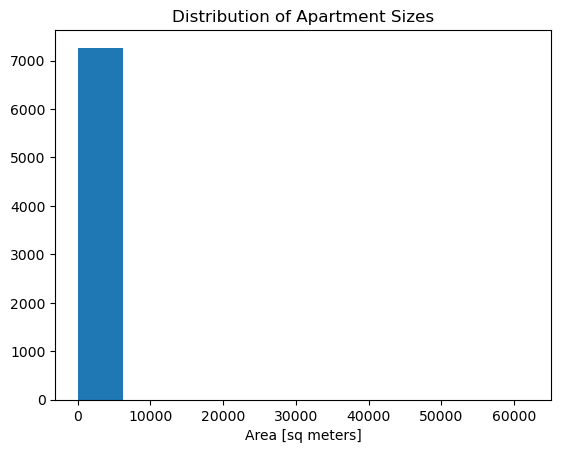

In [7]:
plt.hist(df['surface_covered_in_m2'])
plt.xlabel('Area [sq meters]')
plt.title('Distribution of Apartment Sizes')

plt.show()

In [8]:
new_df = df[
(df['surface_covered_in_m2'] > df['surface_covered_in_m2'].quantile(0.1))
&
(df['surface_covered_in_m2'] < df['surface_covered_in_m2'].quantile(0.9))
]

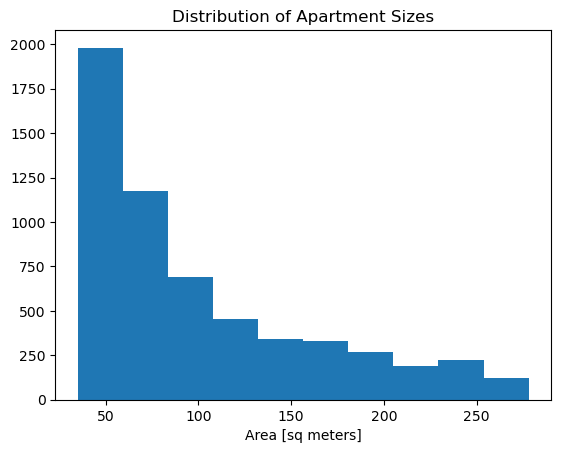

In [9]:
plt.hist(new_df['surface_covered_in_m2'])
plt.xlabel('Area [sq meters]')
plt.title('Distribution of Apartment Sizes')

plt.show()

In [22]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Get place name
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace=True)
    
    # Drop null columns (50%+ null rows)
    nan_cols = nan_columns(df)
    df.drop(columns=nan_cols, inplace=True)
    
    # Drop low- and high-cardinality categorical variables
    df.drop(columns=['operation', 'property_type', 'currency', 'properati_url'], inplace=True)

    # Drop leaky columns
    df.drop(
        columns=['price', 'price_aprox_local_currency', 'price_per_m2', 'price_usd_per_m2'],
        inplace=True
    )
    
    # Drop columns with multicolinearity
    df.drop(columns=['surface_total_in_m2', 'rooms'], inplace=True)
    
    return df

In [23]:
def nan_columns(df):
    cols_series = df.isnull().sum() / len(df)
    return (cols_series[cols_series >= 0.5]).index

In [24]:
df = wrangle('./real-estate-buenos_aires.csv')

In [34]:
ohe = OneHotEncoder(use_cat_names=True)

ohe.fit(df)

df_ae = ohe.transform(df)
print(df_ae.shape)
df_ae.head()

(1343, 57)


,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood_Chacarita,neighborhood_Villa Luro,neighborhood_Caballito,neighborhood_Constitución,neighborhood_Once,neighborhood_Almagro,...,neighborhood_Floresta,neighborhood_Retiro,neighborhood_Versalles,neighborhood_Boca,neighborhood_Puerto Madero,neighborhood_Agronomía,neighborhood_Monte Castro,neighborhood_Tribunales,neighborhood_Villa Santa Rita,neighborhood_Velez Sarsfield
4,129000.00,70.00,-34.58,-58.45,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,87000.00,42.00,-34.64,-58.50,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29,118000.00,54.00,-34.62,-58.46,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40,57000.00,42.00,-34.63,-58.38,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
41,90000.00,50.00,-34.61,-58.41,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
df_ae.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1343 entries, 4 to 8604
Data columns (total 57 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   price_aprox_usd                   1343 non-null   float64
 1   surface_covered_in_m2             1343 non-null   float64
 2   lat                               1300 non-null   float64
 3   lon                               1300 non-null   float64
 4   neighborhood_Chacarita            1343 non-null   int64  
 5   neighborhood_Villa_Luro           1343 non-null   int64  
 6   neighborhood_Caballito            1343 non-null   int64  
 7   neighborhood_Constitución         1343 non-null   int64  
 8   neighborhood_Once                 1343 non-null   int64  
 9   neighborhood_Almagro              1343 non-null   int64  
 10  neighborhood_Palermo              1343 non-null   int64  
 11  neighborhood_Flores               1343 non-null   int64  
 12  neighborhoo

In [47]:
df_ae.columns = df_ae.columns.str.replace('/', '')

In [53]:
feature_matrix = df_ae.drop(columns='price_aprox_usd')
target_vector = df_ae['price_aprox_usd']

formula_str = target_vector.name + ' ~ ' + ' + '.join(feature_matrix)

model = smf.ols(formula=formula_str, data=df_ae)

fitted = model.fit()

print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:        price_aprox_usd   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     51.51
Date:                Thu, 04 Apr 2024   Prob (F-statistic):          1.36e-278
Time:                        18:48:55   Log-Likelihood:                -15363.
No. Observations:                1300   AIC:                         3.084e+04
Df Residuals:                    1244   BIC:                         3.113e+04
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

<Axes: >

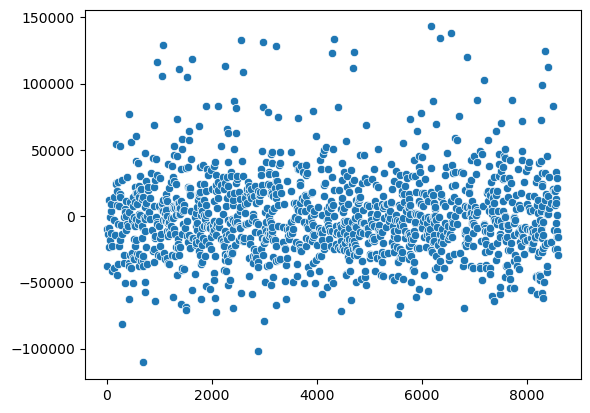

In [54]:
sns.scatterplot(fitted.resid)

In [57]:
pd.read_csv('http://cox.csueastbay.edu/~esuess/classes/Statistics_452/Presentations/ml10a/insurance.csv')

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.90,0,yes,southwest,16884.92
1,18,male,33.80,1,no,southeast,1725.55
2,28,male,33.00,3,no,southeast,4449.46
3,33,male,22.70,0,no,northwest,21984.47
4,32,male,28.90,0,no,northwest,3866.86
...,...,...,...,...,...,...,...
1333,50,male,31.00,3,no,northwest,10600.55
1334,18,female,31.90,0,no,northeast,2205.98
1335,18,female,36.90,0,no,southeast,1629.83
1336,21,female,25.80,0,no,southwest,2007.95
